<a href="https://colab.research.google.com/github/Yeeeens/Big-data-2023/blob/main/GW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
#All imports
import sys
#!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 
import numpy
import pycbc.types
import pylab
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
import pycbc.psd
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries

from scipy import interpolate

import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d

import numpy as np

In [85]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf

!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



In [86]:
#Load data
d = numpy.load('/content/drive/MyDrive/noise_ts_4096Hz.npy')
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data = d

strain = resample_to_delta_t(highpass(data, 15.0), 1.0/2048)
strain = strain.crop(4, 4)
stilde = strain.to_frequencyseries()



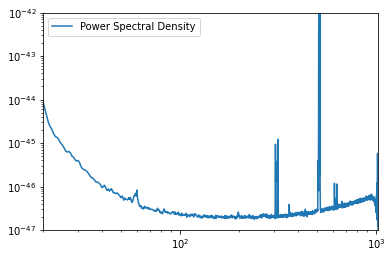

In [87]:
import pycbc.psd
from pycbc.psd import interpolate


#retrieve power specrtal density
delta_t = strain.delta_t
seg_len = int(2 / delta_t)
seg_stride = int(seg_len / 2)
psds = pycbc.psd.welch(strain,
                  seg_len=seg_len,
                  seg_stride=seg_stride)
    
psds = interpolate(psds, stilde.delta_f)

#plot the power spectral density
pylab.loglog(psds.sample_frequencies, psds, label = "Power Spectral Density" )
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.legend()

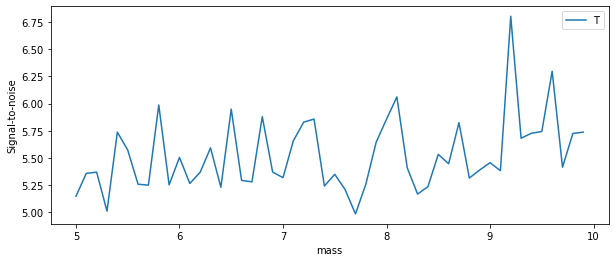

In [15]:


mass1 = numpy.arange(5, 10 , 0.10 ) #mass range bewteen 1 to 3 Solar mass
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain.delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain,
                     psd=psds, low_frequency_cutoff=15.0)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr= snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr)))
snrs = Snr_list

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs, label= 'SNR')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

In [ ]:
#As snr is not above 8 the likely no GW

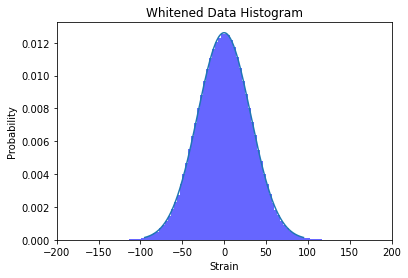

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

#Whiten data
white_data = (strain.to_frequencyseries() / psds**0.5).to_timeseries().crop(4,4)

#make histogram of whitened data 
plt.hist(white_data, bins=150, density=True, alpha=0.6, color='b')

#Create a gaussian curve with zero mean (gotten from stack exchange https://stackoverflow.com/questions/10138085/how-to-plot-normal-distribution)
#should fit perfectly over out data when tweaking variance
mean = 0
variance = 1000
sigma = math.sqrt(variance)
x = np.linspace(mean - 3*sigma, mean + 3*sigma, 300)
plt.plot(x, stats.norm.pdf(x, mean, sigma))

#adjustement and print
plt.xlim(-200, 200)
plt.title("Whitened Data Histogram")
plt.xlabel('Strain')
plt.ylabel('Probability')
plt.show()


Text(0, 0.5, 'Occurence')

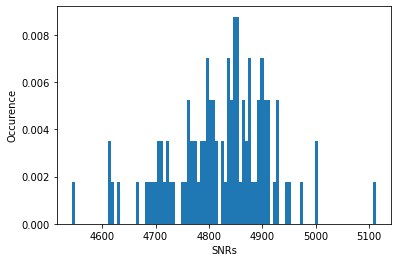

In [93]:
from pycbc.filter import sigmasq

#generate waveform
m=3
hp, hc = get_fd_waveform(approximant="TaylorF2",
                    mass1=m,
                    mass2=m,
                    delta_f=1.0/(200.0),
                    f_lower=20.0, f_final=2048.0)

#cut data into 50 chunks
chunks = int(len(data)/100)

snrList = []
for i in range(100):
  chunk = data[i * chunks : (i+1) * chunks]
  #import psd for chunk
  psd = pycbc.psd.interpolate(pycbc.psd.welch(chunk), hp.delta_f)
  #generate snr for chunk and add to list
  SNR = (pycbc.filter.sigmasq(hp,psd)) ** 0.5
  snrList.append(SNR)

#plot histogram of Snr's
pylab.hist(snrList, bins=100, density=True);
pylab.xlabel('SNRs');
pylab.ylabel('Occurence')


Dont know why the values of snr are so high. However the distribution seems reasonably gaussian 